In [2]:
from NeuralNetwork import Perceptron, ANN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    if (x < 0):
        return 0
    return x

def identity(x):
    return x

def tanh(x):
    return np.tanh(x)

def step(x):
    if x >= 0:
        return 1
    else:
        return 0
    
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X))

def categorical_cross_entropy(y, Yhat):
    sumyhat = 0
    for i in range(len(Yhat)):
        if (i+1) == y:
            sumyhat += np.log(Yhat[i])
    return -sumyhat

In [4]:
def training_perceptron(alpha, k, perceptron, inputs_simple, exp_res, store_results):
    for i in range(k):
        
        #get a random input and output
        which = np.random.randint(low = 0, high = inputs_simple.shape[0])
        X = inputs_simple[which]
        y = exp_res[which]

        #calculate result
        perceptron.inputs = X
        y_hat = perceptron.calc_result()
        #compute loss
        L = y - y_hat
        if i % 10 == 0: #this can help to plot sensible output in case of a lot of training
            store_results.append(abs(L))
        
        #update weights
        perceptron.weights[0] = perceptron.weights[0] + alpha * X[0] * L
        perceptron.weights[1] = perceptron.weights[1] + alpha * X[1] * L
        perceptron.bias = perceptron.bias + alpha * L

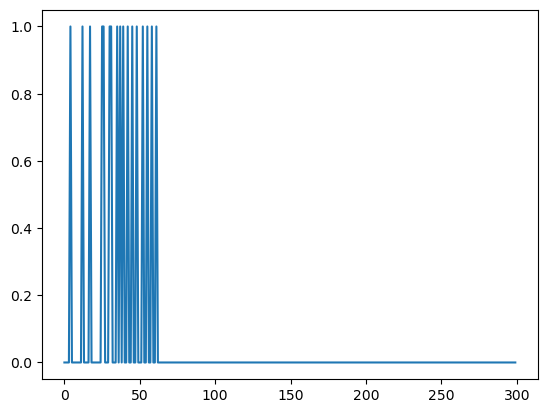

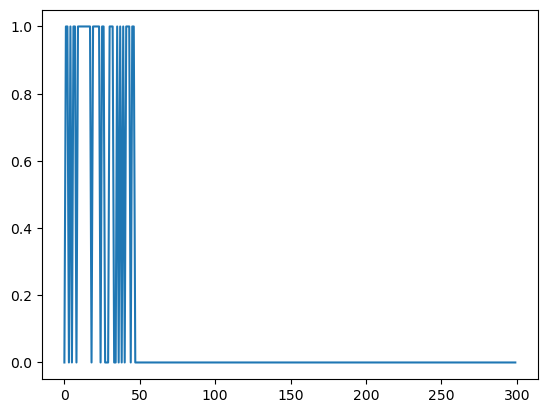

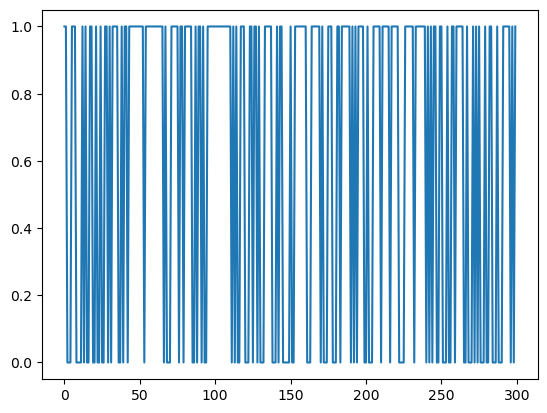

In [5]:
inputs_simple = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
exp_AND = np.array([0, 0, 0, 1])
exp_OR = np.array([0, 1, 1, 1])
exp_XOR = np.array([0, 1, 1, 0])

perceptron = Perceptron(step, np.array([0.5, 0.5]), -50)
results_AND = []
training_perceptron(0.1, 3000, perceptron, inputs_simple, exp_AND, results_AND)
results_OR = []
perceptron = Perceptron(step, np.array([0.5, 0.5]), -50)
training_perceptron(0.1, 3000, perceptron, inputs_simple, exp_OR, results_OR )
results_XOR = []
perceptron = Perceptron(step, np.array([0.5, 0.5]), -50)
training_perceptron(0.1, 3000, perceptron, inputs_simple, exp_XOR, results_XOR)

plt.plot(results_AND)
plt.show()

plt.plot(results_OR)
plt.show()

plt.plot(results_XOR)
plt.show()

In [6]:
def calc_loss(MLP, data):
    ans = 0
    for i in data:
        ans += MLP.loss_function(i[1], MLP.feedforward(i[0]))
    return (ans / len(data))

In [7]:
def accuracy(MLP, data):
    good = 0
    cf_mat = np.zeros((7,7))
    for i in data:
        MLP.feedforward(i[0])
        maxV = MLP.output_layer[0].result
        maxI = 0
        for j in range(1, len(MLP.output_layer)):
            if (MLP.output_layer[j].result > maxV):
                maxV = MLP.output_layer[j].result
                maxI = j
        cf_mat[maxI, i[1] - 1] = cf_mat[maxI, i[1] - 1] + 1
        if (maxI + 1 == i[1]):
            good = good + 1
    plt.show()
    plt.imshow(cf_mat)
    plt.ylabel("Predicted labels")
    plt.xlabel("Actual labels")
    plt.colorbar()
    return good / len(data)
        

In [8]:
def training_MLP(epochs, batch_size, MLP, data, alpha, plot_train = True, plot_val = True, use_relu=False):
    #split the data into three sets: training set (70%), validation set (15%) and test set (15%)
    np.random.shuffle(data)
    training_data = data[0 : int(len(data)*70/100)]
    validation_data = data[int(len(data)*70/100) : int(len(data)*85/100)]
    test_data = data[int(len(data)*85/100) : len(data)-1]
    s = len(training_data)/batch_size
    checkpoints = [int(s/4), 2 * int(s/4), 3* int(s/4), s-1]
    t_losses = np.zeros(epochs * 4)
    v_losses = np.zeros(epochs * 4)
    losses_index = 0
    best_hidden_weights = np.empty((len(MLP.hidden_layer), 10))
    best_hidden_biases = np.empty(len(MLP.hidden_layer))
    best_output_weights = np.empty((len(MLP.output_layer), len(MLP.hidden_layer)))
    best_output_biases = np.empty(len(MLP.output_layer))
    #initialize lowest loss at unrealistically high value
    lowest_loss = 100000
    #if amount increasing reaches a certain value (e.g. 3) stop training early and keep best parameters
    amount_increasing = 0
    
    for i in range(epochs):
        #split training data into training_set_size/batch_size microbatches
        np.random.shuffle(training_data)
        microbatches = np.array_split(training_data, int(s))
        
        for j in range(len(microbatches)):
            avgDeltaWIH = np.zeros((len(MLP.hidden_layer), 10))
            avgDeltaWHO = np.zeros((len(MLP.output_layer), len(MLP.hidden_layer)))
            avgDeltaBIH = np.zeros(len(MLP.hidden_layer))
            avgDeltaBHO = np.zeros(len(MLP.output_layer))
            #print("backprop starts")
            for k in range(len(microbatches[j])):
                
                tempWIH, tempWHO, tempBIH, tempBHO = MLP.backpropagation(input_layer = microbatches[j][k][0], 
                                                       expected_result = microbatches[j][k][1], use_relu=use_relu)
                avgDeltaWIH = np.add(avgDeltaWIH, tempWIH)
                avgDeltaWHO = np.add(avgDeltaWHO, tempWHO)
                avgDeltaBIH = np.add(avgDeltaBIH, tempBIH)
                avgDeltaBHO = np.add(avgDeltaBHO, tempBHO)
                
            avgDeltaWIH = np.divide(avgDeltaWIH, len(microbatches[j]))
            avgDeltaWHO = np.divide(avgDeltaWHO, len(microbatches[j]))
            avgDeltaBIH = np.divide(avgDeltaBIH, len(microbatches[j]))
            avgDeltaBHO = np.divide(avgDeltaBHO, len(microbatches[j]))
            #print("backprop ends")
            #print("updating starts")
            MLP.update(avgDeltaWIH, avgDeltaWHO, avgDeltaBIH, avgDeltaBHO, alpha)
            if j in checkpoints and losses_index < len(t_losses):
                if plot_train:
                    t_losses[losses_index] = calc_loss(MLP, training_data)
                v_losses[losses_index] = calc_loss(MLP, validation_data)
                if (v_losses[losses_index] < lowest_loss):
                    lowest_loss = v_losses[losses_index]
                    for k in range(len(best_hidden_biases)):
                        hidden_node = MLP.hidden_layer[k]
                        best_hidden_biases[k] = hidden_node.bias
                        best_hidden_weights[k] = hidden_node.weights
                    for k in range(len(best_output_biases)):
                        output_node = MLP.output_layer[k]
                        best_output_biases[k] = output_node.bias
                        best_output_weights[k] = output_node.weights
                    amount_increasing = 0
                else:
                    amount_increasing = amount_increasing + 1
                losses_index = losses_index + 1
                #print(t_losses[-1], " ", v_losses[-1])
            if amount_increasing > 2:
                for k in range(len(best_hidden_biases)):
                    hidden_node = MLP.hidden_layer[k]
                    hidden_node.weights = best_hidden_weights[k]
                    hidden_node.bias = best_hidden_biases[k]
                for k in range(len(best_output_biases)):
                    output_node = MLP.output_layer[k]
                    output_node.weights = best_output_weights[k]
                    output_node.bias = best_output_biases[k]
                break
        if amount_increasing > 2:
            break
        #t_losses.append(calc_loss(MLP, training_data))
        #v_losses.append(calc_loss(MLP, validation_data))
    if plot_train:
        t_losses = t_losses[0:losses_index]
    v_losses = v_losses[0:losses_index]
    if plot_train:
        plt.plot(t_losses, label="training")
    if plot_val:
        plt.plot(v_losses, label="validation")
    #plt.ylabel('loss')
    #plt.legend(loc="upper left")
    return accuracy(MLP, validation_data), accuracy(MLP, test_data)
            
            
                
    

In [33]:
import_data = pd.read_csv('./../data/features.txt', sep=",", header = None)
df = pd.DataFrame(import_data).T
target_data = pd.read_csv('./../data/targets.txt', sep=",", header = None)

data = [[0 for x in range(2)] for y in range(df.shape[1])]

for i in range(df.shape[1]):
    for j in range(len(df[i])):
        data[i][0] = df[i]
    data[i][1] = target_data[0][i]

data = np.asarray(data, dtype=object)

In [10]:
def buildANNNormal(hid_size):
    hidden_layer = []
    for i in range(hid_size):
        perceptron = Perceptron(sigmoid, np.random.normal(0, 1, 10), 0)
        hidden_layer.append(perceptron)
    output_layer = []
    for i in range(7):
        perceptron = Perceptron(softmax, np.random.normal(0, 1, hid_size), 0)
        output_layer.append(perceptron)
    ann = ANN(hidden_layer, output_layer, categorical_cross_entropy, softmax, 1)
    return ann

In [11]:
def buildANNConstant(hid_size):
    hidden_layer = []
    for i in range(hid_size):
        perceptron = Perceptron(sigmoid, np.full(10, 0.5), 0)
        hidden_layer.append(perceptron)
    output_layer = []
    for i in range(7):
        perceptron = Perceptron(softmax, np.full(hid_size, 0.5), 0)
        output_layer.append(perceptron)
    ann = ANN(hidden_layer, output_layer, categorical_cross_entropy, softmax, 1)
    return ann

In [12]:
def buildANNXavier(hid_size):
    hidden_layer = []
    for i in range(hid_size):
        perceptron = Perceptron(sigmoid, np.random.normal(0, 1/10, 10), 0)
        hidden_layer.append(perceptron)
    output_layer = []
    for i in range(7):
        perceptron = Perceptron(softmax, np.random.normal(0, 1/hid_size, hid_size), 0)
        output_layer.append(perceptron)
    ann = ANN(hidden_layer, output_layer, categorical_cross_entropy, softmax, 1)
    return ann

In [13]:
#results = []

#for i in range(10):
#    print(training_MLP(epochs=5, batch_size=8, MLP=buildANNNormal(8), data=data, alpha=0.1))


#plt.show()

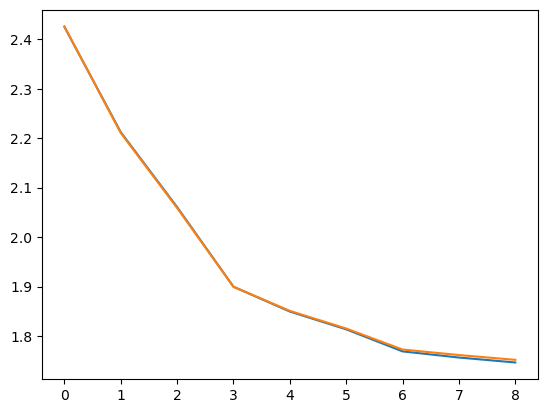

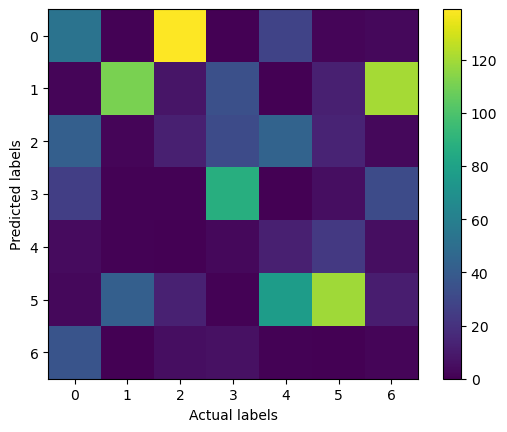

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy:  0.3361629881154499


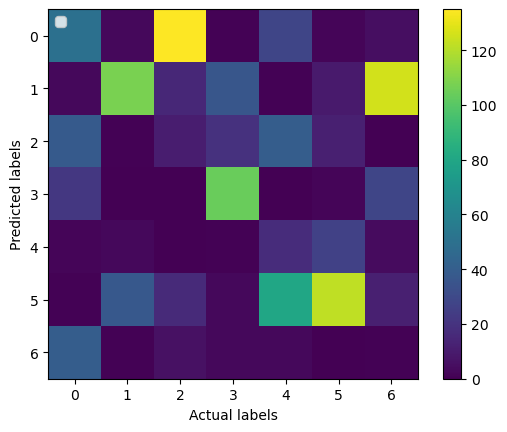

In [15]:
results = []

# Testing training with few epochs for the purpose of looking at our plot styling
print("accuracy: ", training_MLP(epochs=3, batch_size=8, MLP=buildANNNormal(8), data=data, alpha=0.01)[0])
plt.legend(loc="upper left")
plt.show()

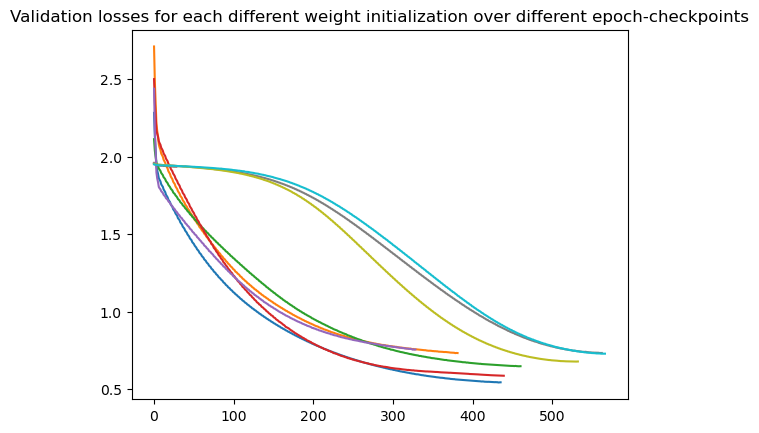

In [116]:
accuracies = []

# Train five models using standard normal distribution weight initialization
for i in range(5):
    accuracies.append(training_MLP(epochs=200, batch_size=8, MLP=buildANNNormal(8), data=data, alpha=0.01, plot_train=False)[0])

# Train five models using Xavier initialization
for i in range(5):
    accuracies.append(training_MLP(epochs=200, batch_size=8, MLP=buildANNXavier(8), data=data, alpha=0.01, plot_train=False)[0])
plt.title(label="Validation losses for each different weight initialization over different epoch-checkpoints")
plt.show()

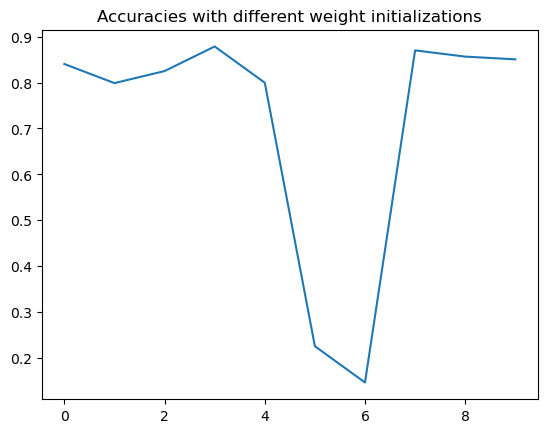

In [118]:
plt.plot(accuracies, label="accuracy with different weight initializations:")
plt.title(label="Accuracies with different weight initializations")
plt.show()

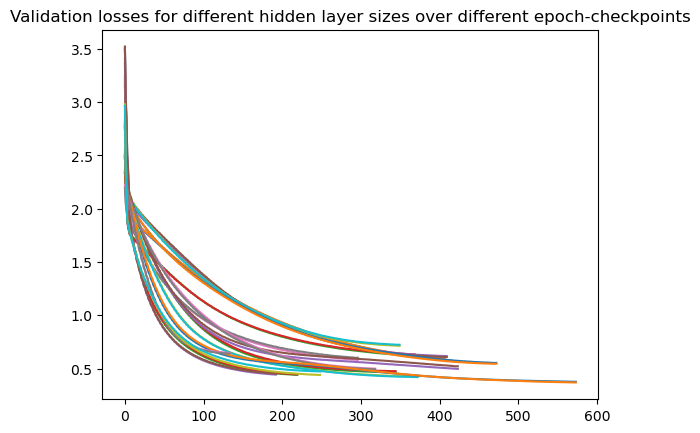

In [119]:
hidden_node_accs = []
amount_of_hidden_nodes = [7, 12, 18, 24, 30]

# Train models with different amounts of hidden nodes, taking the average over multiple trainings to defer effects of random weight initialization
for x in amount_of_hidden_nodes:
    temp_acc = []
    for i in range(3):
        temp_acc.append(training_MLP(epochs=200, batch_size=8, MLP=buildANNNormal(x), data=data, alpha=0.01))
    hidden_node_accs.append(np.average(np.asarray(temp_acc)))
plt.title(label="Validation losses for different hidden layer sizes over different epoch-checkpoints")
plt.show()

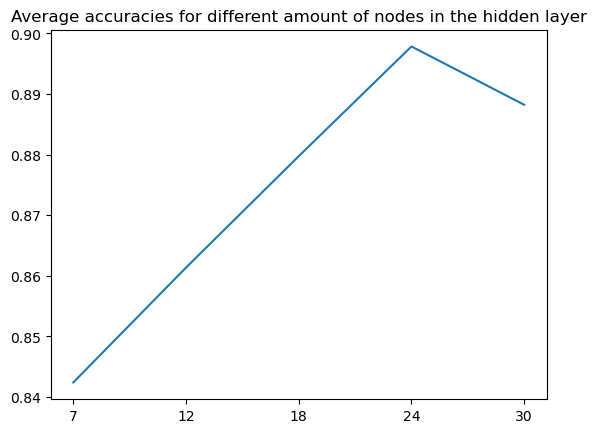

In [120]:

plt.plot(range(len(amount_of_hidden_nodes)), hidden_node_accs)
plt.xticks(range(len(amount_of_hidden_nodes)), amount_of_hidden_nodes)
plt.title(label="Average accuracies for different amount of nodes in the hidden layer")
plt.show()

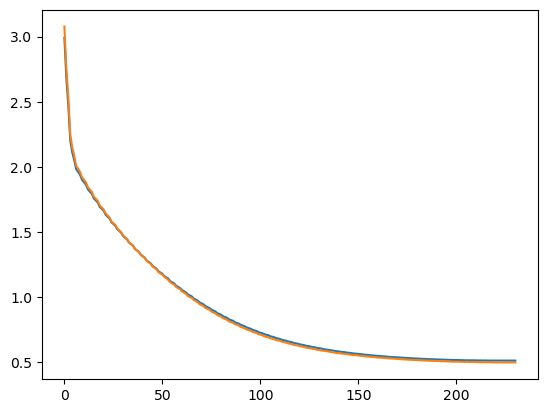

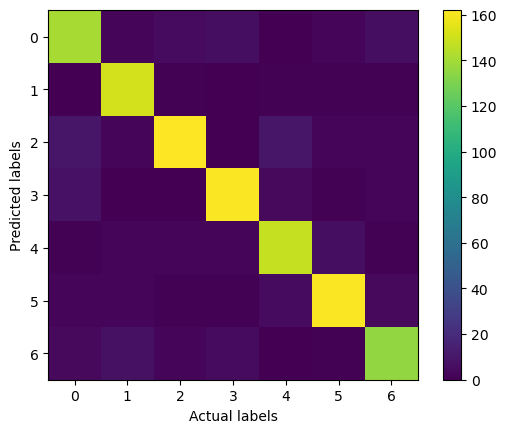

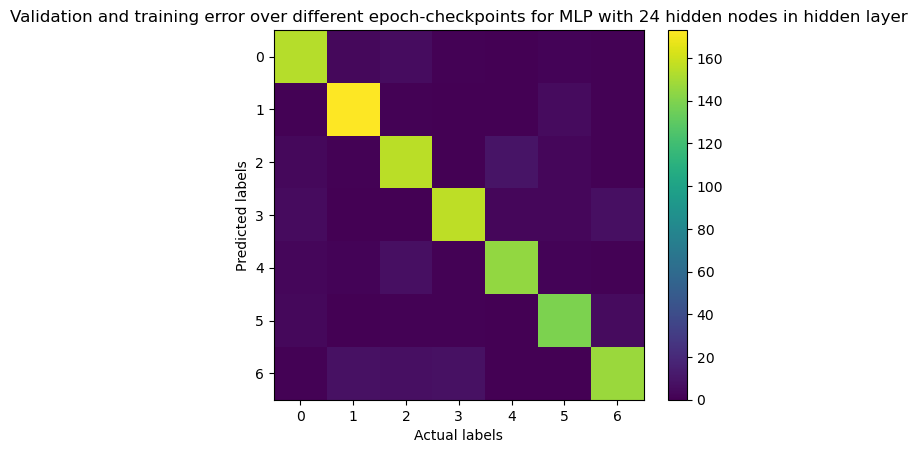

In [21]:
#The graphs may differ slightly from what's in the report, due to us having to re-run this cell and thus reinitializing the weights of the model
final_mlp = buildANNNormal(24)
acc_final_mlp = training_MLP(epochs=200, batch_size=8, MLP=final_mlp, data=data, alpha=0.01)
plt.title("Validation and training error over different epoch-checkpoints for MLP with 24 hidden nodes in hidden layer")
plt.show()

In [22]:
print("Accuracy on validation set: ", acc_final_mlp[0])
print("Accuracy on test set: ", acc_final_mlp[1])

Accuracy on validation set:  0.8998302207130731
Accuracy on test set:  0.9074702886247877


In [52]:
unknown_data = pd.read_csv('./../data/unknown.txt', sep=",", header = None)
ud = pd.DataFrame(unknown_data).T
predicted = []
for i in range(ud.shape[1]):
    probs = final_mlp.feedforward(ud[i])
    predicted.append(np.argmax(np.asarray(probs)) + 1)
pre_df = pd.DataFrame(predicted).T
print(pre_df)
pre_df.to_csv("./../71_classes.txt", header=None, index=None, sep=',')

   0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0    2    6    7    1    6    5    1    3    7    7  ...    5    5    7    2   

   778  779  780  781  782  783  
0    2    2    2    6    2    1  

[1 rows x 784 columns]


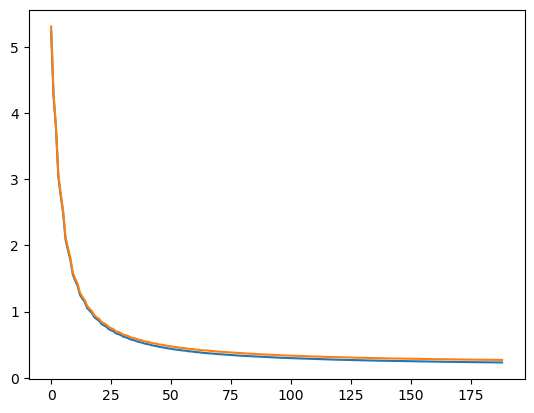

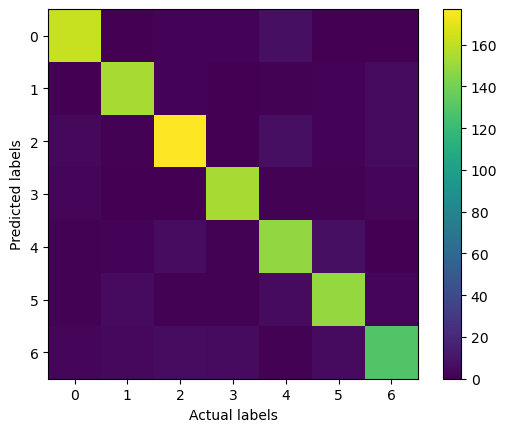

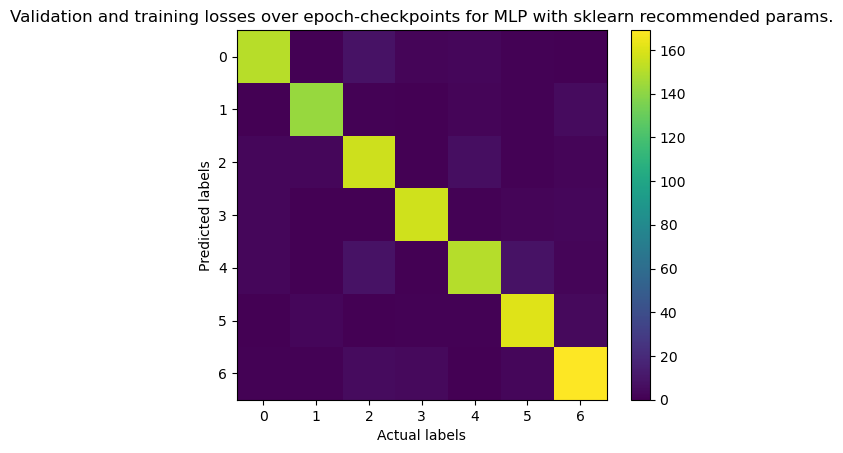

In [53]:
def buildANNNormalRelu(hid_size):
    hidden_layer = []
    for i in range(hid_size):
        perceptron = Perceptron(relu, np.random.normal(0, 1, 10), 0)
        hidden_layer.append(perceptron)
    output_layer = []
    for i in range(7):
        perceptron = Perceptron(softmax, np.random.normal(0, 1, hid_size), 0)
        output_layer.append(perceptron)
    ann = ANN(hidden_layer, output_layer, categorical_cross_entropy, softmax, 1)
    return ann

model_skparams = buildANNNormalRelu(24)
acc_model_skparams = training_MLP(epochs=200, batch_size=8, MLP=model_skparams, data=data, alpha=0.01, use_relu=True)
plt.title("Validation and training losses over epoch-checkpoints for MLP with sklearn recommended params.")
plt.show()

In [54]:
print("Validation and test accuracy: ", acc_model_skparams)

Validation and test accuracy:  (0.9108658743633277, 0.9227504244482173)
